Evaluation of baseline logistic model

In [1]:
import joblib
import pandas as pd
from utils import (
    load_and_split_data,
    extract_basic_features,
    evaluate_model
)

import spacy
from utils import nlp as utils_nlp

# Ensure SpaCy model is loaded and assigned to utils
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("Downloading SpaCy model 'en_core_web_md'...")
    from spacy.cli import download
    download("en_core_web_md")
    nlp = spacy.load("en_core_web_md")

# Assign it to utils
import utils
utils.nlp = nlp


# Load Data

train_df, val_df, test_df = load_and_split_data()


# Load Model

model_path = "models/logistic_basic.pkl"
model = joblib.load(model_path)
print(f"Loaded model from {model_path}")


# Extract Features

X_train = extract_basic_features(train_df)
y_train = train_df['is_duplicate']

X_val = extract_basic_features(val_df)
y_val = val_df['is_duplicate']

X_test = extract_basic_features(test_df)
y_test = test_df['is_duplicate']


# Evaluate
results = {
    "Train": evaluate_model(model, X_train, y_train),
    "Validation": evaluate_model(model, X_val, y_val),
    "Test": evaluate_model(model, X_test, y_test)
}



results_df = pd.DataFrame(results).T
print('Results:')
display(results_df)


Loaded model from models/logistic_basic.pkl
Results:


,roc_auc,precision,recall
Train,0.724121,0.521397,0.302559
Validation,0.723751,0.524119,0.299100
Test,0.721670,0.521372,0.298485


ROC AUC 0.72: Not bad for a single feature. The model can distinguish duplicates somewhat better than random.

Low precision & recall: Indicates the model struggles to correctly identify duplicates.

    

------

Evaluation of improved baseline model


In [2]:
import joblib
import pandas as pd
from utils import (
    load_and_split_data,
    extract_improved_features,
    evaluate_model
)

# Load Data

train_df, val_df, test_df = load_and_split_data()


# Load Model and TF-IDF Vectorizer

model_path = "models/logistic_improved.pkl"
vectorizer_path = "models/tfidf_vectorizer.pkl"

model = joblib.load(model_path)
tfidf_vectorizer = joblib.load(vectorizer_path)

print("Model and vectorizer loaded successful")



# Extract Features

X_train, _ = extract_improved_features(train_df, tfidf_vectorizer)
y_train = train_df['is_duplicate']

X_val, _ = extract_improved_features(val_df, tfidf_vectorizer)
y_val = val_df['is_duplicate']

X_test, _ = extract_improved_features(test_df, tfidf_vectorizer)
y_test = test_df['is_duplicate']


# Evaluate

results = {
    "Train": evaluate_model(model, X_train, y_train),
    "Validation": evaluate_model(model, X_val, y_val),
    "Test": evaluate_model(model, X_test, y_test)
}


results_df = pd.DataFrame(results).T
display(results_df)


Model and vectorizer loaded successful


,roc_auc,precision,recall
Train,0.776275,0.611589,0.505469
Validation,0.765984,0.596026,0.492324
Test,0.767731,0.600799,0.500583


Consistency across all three sets (train/val/test) shows:

- No significant overfitting

- Good generalization

ROC AUC +-0.77 is a strong score for this dataset, especially using only engineered features (no deep learning or embeddings)

Precision = 0.60 and Recall = 0.50 are also decent,this means:

- The model is finding duplicates with decent accuracy

- It's not being too conservative (balanced recall)

----

Evaluation: Grid-searched logistic + Random forest

In [3]:

import joblib
import pandas as pd
from utils import (
    load_and_split_data,
    extract_improved_features,
    evaluate_model
)

# Load Data and Vectorizer

train_df, val_df, test_df = load_and_split_data()
tfidf_vectorizer = joblib.load("models/tfidf_vectorizer.pkl")

X_train, _ = extract_improved_features(train_df, tfidf_vectorizer)
y_train = train_df['is_duplicate']

X_val, _ = extract_improved_features(val_df, tfidf_vectorizer)
y_val = val_df['is_duplicate']

X_test, _ = extract_improved_features(test_df, tfidf_vectorizer)
y_test = test_df['is_duplicate']


# Load Models

model_paths = {
    "Logistic Regression": "models/logistic_model.pkl",
    "Random Forest": "models/random_forest_model.pkl"
}

models = {name: joblib.load(path) for name, path in model_paths.items()}
print("Loaded all models and vectorizer.")


# Evaluate models

results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}")
    results[name] = {
        "Train": evaluate_model(model, X_train, y_train),
        "Validation": evaluate_model(model, X_val, y_val),
        "Test": evaluate_model(model, X_test, y_test)
    }


# Display results

frames = []
for model_name, scores in results.items():
    df = pd.DataFrame(scores).T
    df['Model'] = model_name
    frames.append(df)

results_df = pd.concat(frames).reset_index().rename(columns={"index": "Set"})
results_df = results_df[['Model', 'Set', 'roc_auc', 'precision', 'recall']]

display(results_df)


Loaded all models and vectorizer.

Evaluating Logistic Regression

Evaluating Random Forest


,Model,Set,roc_auc,precision,recall
0,Logistic Regression,Train,0.776304,0.611804,0.505692
1,Logistic Regression,Validation,0.766001,0.595904,0.492853
2,Logistic Regression,Test,0.767754,0.601238,0.501249
3,Random Forest,Train,0.999747,0.999146,0.999916
4,Random Forest,Validation,0.813626,0.631150,0.629257
5,Random Forest,Test,0.812648,0.629946,0.625437


Logistic Regression:
Same performance as previously (as expected since it’s the same model).
Strong, consistent baseline. AUC 0.77, not bad precision/recall.

Random Forest:
Much higher performance, especially on validation/test sets.
Very high training scores (0.999) means model is overfitting, but generalizes well thanks to validation/test performance.

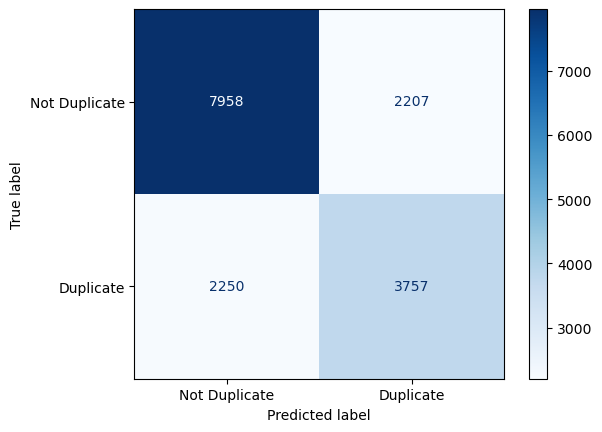

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Predict on test set using best model 
best_model = models["Random Forest"]
y_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Duplicate", "Duplicate"])
disp.plot(cmap="Blues")


**Confusion matrix**

- Balanced Error: The false positives and false negatives are equal more or less,  suggesting the model is not heavily biased toward one class.

- Class Handling: the model is managing the class imbalance quite well. Both types of error are in the 2,200 range, which is solid for a real world text classification task.

- Precision vs Recall: Slightly more false negatives, means the model is a little conservative in labeling duplicates. But overall recall is still +-0.63, which is strong.

In [5]:
test_df["pred"] = y_pred
wrong_preds = test_df[test_df["pred"] != test_df["is_duplicate"]]

# Show 5 false positives (predicted duplicate but it isn't)
print("False Positives:")
display(wrong_preds[(wrong_preds["pred"] == 1)].sample(5))

# Show 5 false negatives (predicted not duplicate but it is)
print("False Negatives:")
display(wrong_preds[(wrong_preds["pred"] == 0)].sample(5))


False Positives:


,id,qid1,qid2,question1,question2,is_duplicate,pred
238670,131523,210833,210834,How do roller ball pens work?,How does a ball pen work?,0,1
194310,220201,327260,327261,Do people make money from Quora posts?,Are there people making money on Quora?,0,1
190896,190023,288977,143238,How can I deal with my parents and myself?,How do i deal with my parents?,0,1
41388,197363,298301,298302,"What is it like to have cancer, or know someon...",What is it like to be told you have cancer?,0,1
320051,271138,389167,389168,"Should I buy a MacBook Air, MacBook, or MacBoo...",Where should I buy the MacBook Air or MacBook ...,0,1


False Negatives:


,id,qid1,qid2,question1,question2,is_duplicate,pred
266734,284703,278308,48687,Which is the best company to invest in shares?,What are the best companies in which you can i...,1,0
200003,58444,102524,102525,How do you plan to reform education in the Uni...,Will the United States ever reform their educa...,1,0
1131,105330,173725,136110,Who is considered the most beautiful woman in ...,Who are the most handsome man and beautiful wo...,1,0
59562,44953,46690,80621,What is the use of Linux?,What is Linux?,1,0
187751,231839,341733,341734,Are women really smarter than men?,What made women smarter than men?,1,0


- Many false positives occur when the questions are topically related but not semantically equivalent, showing that the model is probably sensitive to shared keywords or structure.

- Most false negatives happen when questions are semantically aligned but use different phrasing or structure. These could be better captured with deeper semantic embeddings or a transformer-based model.

